## **Importing libraries and datasets**

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [ ]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [85]:
# Lasted Active Transaction (2years)
df_transactions_2y = df_transactions.loc[df_transactions['trans_date'] > '2013-03-17']
df_transactions_2y

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
9,CS3802,2013-08-20,75,574.0
...,...,...,...,...
124991,CS8076,2014-05-16,68,305.0
124996,CS7232,2014-08-19,38,210.0
124997,CS8731,2014-11-28,42,109.0
124998,CS8133,2013-12-14,13,458.0


In [86]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions_2y['recent']= campaign_date - df_transactions['trans_date']
df_transactions_2y['recent'].astype('timedelta64[D]')
df_transactions_2y['recent']=df_transactions_2y['recent'] / np.timedelta64(1, 'D')
df_transactions_2y.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
9,CS3802,2013-08-20,75,574.0


In [87]:
## create data set with RFM variables

df_rfm = df_transactions_3M.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [88]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,6,358
1,CS1113,36.0,11,775
2,CS1114,33.0,11,804
3,CS1115,12.0,11,831
4,CS1116,204.0,5,333


In [89]:
## create data set with CLV variables

df_clv = df_transactions_3M.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [90]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,6,358,562,59.666667
1,CS1113,36.0,11,775,660,70.454545
2,CS1114,33.0,11,804,626,73.090909
3,CS1115,12.0,11,831,715,75.545455
4,CS1116,204.0,5,333,199,66.600000


## **Calculating response rate**

In [91]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()


response_rate.head()

,response,customer_id
0,0,6237
1,1,647


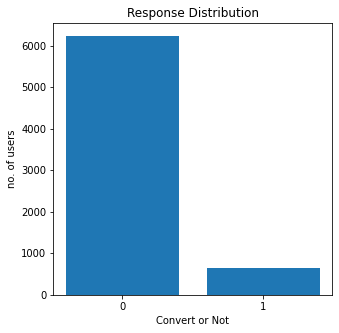

In [92]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [93]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,6,358
1,CS1113,0,36.0,11,775
2,CS1114,1,33.0,11,804
3,CS1115,1,12.0,11,831
4,CS1116,1,204.0,5,333


In [94]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,6,358,562,59.666667
1,CS1113,0,36.0,11,775,660,70.454545
2,CS1114,1,33.0,11,804,626,73.090909
3,CS1115,1,12.0,11,831,715,75.545455
4,CS1116,1,204.0,5,333,199,66.600000


## **Creating train and test dataset**

In [95]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [96]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

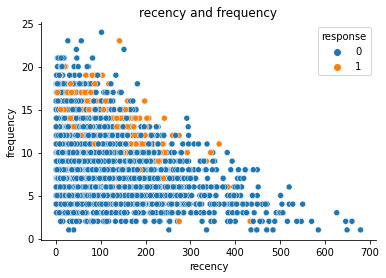

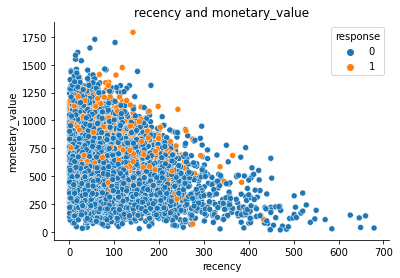

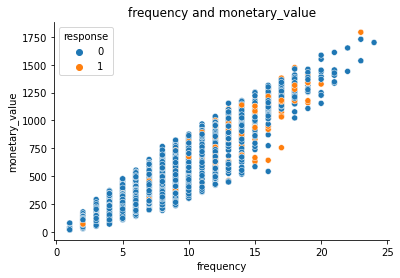

In [97]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

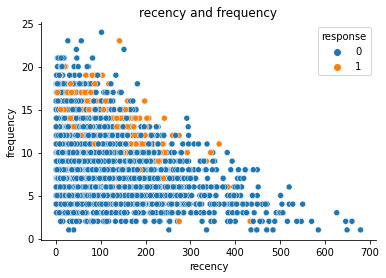

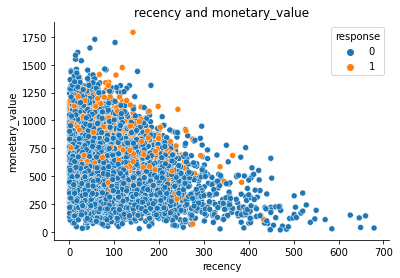

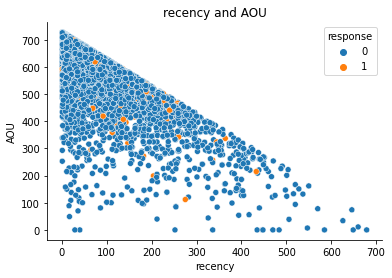

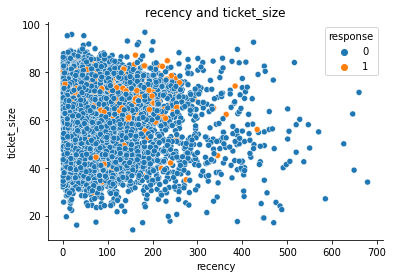

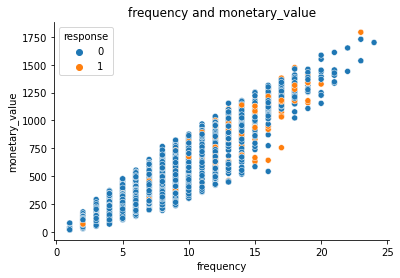

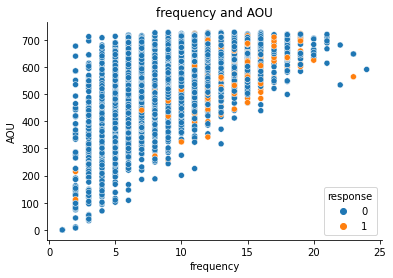

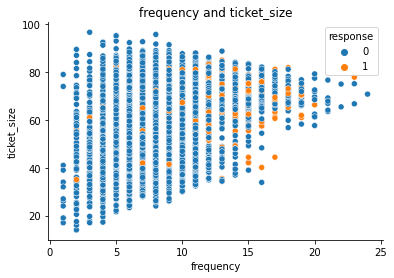

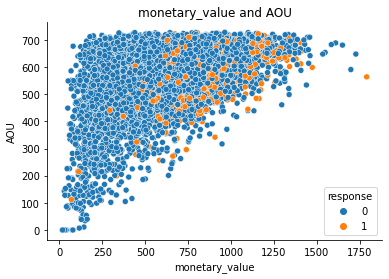

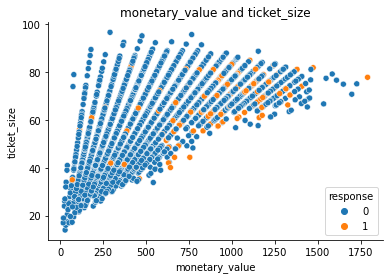

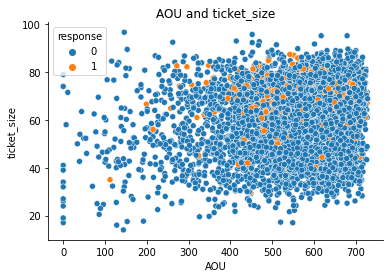

In [98]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [99]:
sm = SMOTE(random_state=0)
# X, y = oversample.fit_resample(X, y)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [100]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      4389
           1       0.71      0.77      0.74      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.76      0.34       218

    accuracy                           0.69      2066
   macro avg       0.59      0.72      0.57      2066
weighted avg       0.88      0.69      0.75      2066



In [101]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      4389
           1       0.73      0.75      0.74      4389

    accuracy                           0.74      8778
   macro avg       0.74      0.74      0.74      8778
weighted avg       0.74      0.74      0.74      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1848
           1       0.22      0.69      0.34       218

    accuracy                           0.72      2066
   macro avg       0.59      0.70      0.58      2066
weighted avg       0.87      0.72      0.77      2066



## **XGBoost**

In [102]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

X_SMOTE_rfm = X_SMOTE_rfm.values
y_SMOTE_rfm = y_SMOTE_rfm.values

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.567615
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.760123
[2]	validation_0-auc:0.750024
[3]	validation_0-auc:0.738471
[4]	validation_0-auc:0.755713
[5]	validation_0-auc:0.759012
[6]	validation_0-auc:0.762043
[7]	validation_0-auc:0.772446
[8]	validation_0-auc:0.771402
[9]	validation_0-auc:0.772104
[10]	validation_0-auc:0.769835
[11]	validation_0-auc:0.769634
[12]	validation_0-auc:0.769818
Stopping. Best iteration:
[7]	validation_0-auc:0.772446

training set
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      4389
           1       0.70      0.84      0.76      4389

    accuracy                           0.74      8778
   macro avg       0.75      0.74      0.74      8778
weighted avg       0.75      0.74      0.74      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1848
   

In [103]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

X_SMOTE_clv = X_SMOTE_clv.values
y_SMOTE_clv = y_SMOTE_clv.values

# model = pickle.load(open("saved_model_file", "rb"))
# cols_when_model_builds = model.get_booster().feature_names
# pd_dataframe = pd_dataframe[cols_when_model_builds]

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.743677
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.747103
[2]	validation_0-auc:0.775006
[3]	validation_0-auc:0.775098
[4]	validation_0-auc:0.779258
[5]	validation_0-auc:0.779164
[6]	validation_0-auc:0.779261
[7]	validation_0-auc:0.780693
[8]	validation_0-auc:0.776279
[9]	validation_0-auc:0.779903
[10]	validation_0-auc:0.777823
[11]	validation_0-auc:0.778253
[12]	validation_0-auc:0.778493
Stopping. Best iteration:
[7]	validation_0-auc:0.780693

training set
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      4389
           1       0.66      0.89      0.76      4389

    accuracy                           0.72      8778
   macro avg       0.75      0.72      0.71      8778
weighted avg       0.75      0.72      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.54      0.70      1848
   

In [104]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [105]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42,shuffle=True)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [106]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7627935998911987
[[1158  690]
 [  45  173]]
test set
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      1848
           1       0.20      0.79      0.32       218

    accuracy                           0.64      2066
   macro avg       0.58      0.71      0.54      2066
weighted avg       0.88      0.64      0.71      2066



In [107]:
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train_clv, xgb_model_clv_GS.predict_proba(X_train_clv)[:, 1])

auc_test = roc_auc_score(y_test_clv, xgb_model_clv_GS.predict_proba(X_test_clv)[:, 1])

print(f"AUC Train : {auc_train:.4f}")
print(f"AUC Test : {auc_test:.4f}")

AUC Train : 0.7939
AUC Test : 0.7607


In [108]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f186b726320>}
